# Tutoriel de machine learning non supervisé avec K-means

Le but de ce tutoriel sera de prendre un set de donnée et créer un modèle de machine learning qui devra classer ses données sans qu'on lui donne de paramètres. Le résultat attendu sera de classer en 3 groupes distinct les données par similarité

Ce classement sera fait à l'aide d'un centroide. Le centroide est le point que l'on va determiner grace a la distance moyenne de tous les points du cluster
Il y'aura donc un centroide par cluster, dans notre exemple 3 centroide.

### Importation des différentes librairies

In [2]:
from sklearn.datasets import load_iris
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
import numpy as np

### Importation du dataset et affichage d'infos sur les données

In [15]:
from sklearn.datasets import load_iris
data = load_iris()
data, labels = load_iris(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 3; # samples: 150; # features 4


Nous avons 150 echantillons qui comprennent 4 composants

Nous allons maintenant créer une fonction qui nous permettra de tester différentes manière de caculer les clusters. Le paramètre principale que nous allons modifier est l'initialisation du centroide.
il existe différente manière de l'initialiser et c'est pour cette raison que nous allons créer la fonction qui prendra comme paramètre l'initialisation.
Cette fonction nous évitera de devoir relancer cette section de code en entière à chaque nouveau paramètre.
La fonction nous permettra aussi d'afficher différentes valeurs de résultats qui nous permettront d'évaluer la meilleur initialisation.

In [5]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

Nous allons maintenant utiliser la fonction précédente avec 3 paramètres d'initialisation différente et pour chacun d'entre eux evaluer les resultats selon :
    - le temps de calcul
    - homogeneity_score (si les points d'un cluster ont bien le même label)
    - completness_score ( si les points d'un label ont bien le même cluster)
    - v_measure_score ( la moyenne entre l'homogeity_score et le completness_score)
    - l'ajusted rand score et le mutual info score necessite des connaissances plus approfondies et je vous laisse si cela vous interesse vous renseigner sur ses deux valeurs

Les 3 méthodes d'initialisation des centroides seront les suivantes : 
 - Kmeans++ : le but de cette initialisation est d'éparpiller le plus possible le centroide dans le jeu de donnée
 - random : initialisation de manière totalement aléatoire 
 - Pca-based : interpreter les donnés pour les mettre dans un environnement en 2D(a la place de 4D) et permettre de calculer les centroides en une seule fois

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.269s	69662	0.680	0.719	0.699	0.570	0.695	0.177
random   	0.153s	69707	0.675	0.716	0.694	0.560	0.691	0.168
PCA-based	0.056s	72686	0.636	0.658	0.647	0.521	0.643	0.131
__________________________________________________________________________________


D'après le tableau ci dessus, nous allons considérer que le plus performant est le k-means++, c'est celui qui est proposé par défault avec k-means

PCA va nous permettre de transformer notre environnement 4D (notre échantillon a 4 composante) en 2D.
Matplotlib va nous permettre d'afficher visuellement nos 3 regroupement d'échantillon grâce a la transformation en 2D de PCA
Les centroides de chaque cluster seront affichés par des croix blanches.


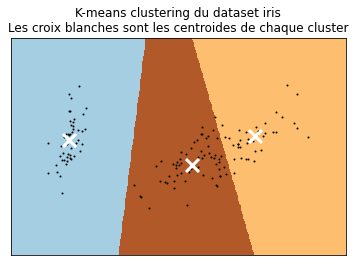

In [19]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering du dataset iris\n"
    "Les croix blanches sont les centroides de chaque cluster"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()